## Improve a model
First predictions = baseline predictions.
First model = baseline model.

From a data perspective:
* Could we collect more data? (generally, the more data, the better) 
* Could we improve our data? 

From a model perspective:
* Is there a better model we could use?
* Could we improve the current model? 

Hyperparameters vs. Parameters
* Parameters = model find these patterns in data
* Hyperparameters = settings on a model you can adjust to (potentially) improve its ability to find patterns

Three ways to adjust hyperparameters:
1. By hand
2. Randomly with RandomSearchCV
3. Exhaustively with GridSearchCV

In [1]:
#Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
heart_disease = pd.read_csv('Dataset/heart-disease.csv')
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

When you instantiate a model like above, you're using the default hyperparameters.

These get printed out when you call the model instance and `get_params()`.

In [4]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We'll try tuning these as well as:
* `max_features` (the number of features to consider when looking for the best split)
* `max_depth` (the maximum depth of the tree)
* `min_samples_leaf` (the minimum number of samples required to be at a leaf node)
* `n_estimators` (the number of trees in the forest) and 
* `min_samples_split` (the minimum number of samples required to split an internal node).


To get familar with hyperparameter tuning, we'll take our RandomForestClassifier and adjust its hyperparameters in 3 ways.

1. By hand
2. Randomly with [RandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
3. Exhaustively with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


### 5.1 Tuning hyperparameters by hand
Let's make 3 sets, training, validation and test.

In [5]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [6]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

# Shuffle the data
heart_disease = heart_disease.sample(frac=1)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split the data into train, validation & test sets
train_split = round(0.7 * len(heart_disease)) # 70% of data
valid_split = round(train_split + 0.15 * len(heart_disease)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_valid)

# Evaluate the classifier
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Acc: 82.22%
Precision: 0.81
Recall: 0.88
F1 score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

Beautiful, now let's try and improve the results.

We'll change 1 of the hyperparameters, `n_estimators` to 100 and see if it improves on the validation set.

In [8]:
np.random.seed(42)

# Create a second classifier
clf_2 = RandomForestClassifier(n_estimators=100)
clf_2.fit(X_train, y_train)

# Make predictions
y_preds_2 = clf_2.predict(X_valid)

# Evaluate the 2nd classifier
clf_2_metrics = evaluate_preds(y_valid, y_preds_2)

Acc: 82.22%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


### 5.2 Hyperparameter tuning with [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) allows us to randomly search across different hyperparameters to see which work best. It also stores details about the ones which work best!

Let's see it in action.

First, we create a grid (dictionary) of hyperparameters we'd like to search over.

In [9]:
# Hyperparameter grid RandomizedSearchCV will search over
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

Scikit-Learn's `RandomizedSearchCV` will look at it, pick a random value from each, instantiate a model with those values and test each model.

How many models will it test?

As many as there are for each combination of hyperparameters to be tested. Let's add them up.

`max_depth` has 4, `max_features` has 2, `min_samples_leaf` has 3, `min_samples_split` has 3, `n_estimators` has 5. That's 4x2x3x3x5 = 360 models!

Or...

We can set the `n_iter` parameter to limit the number of models `RandomizedSearchCV` tests.

In [10]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all cores (NOTE: n_jobs=-1 is broken as of 8 Dec 2019, using n_jobs=1 works)
clf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=20, # try 20 models total
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   8.0s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.2s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   6.6s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.7s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.3s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=30 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=30, total=   0.7s
[CV] n_estimators=100, min_samples_split=4, min_samp

[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   1.0s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   1.0s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   1.2s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=20 
[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=20, total=   5.6s
[CV] n_estimators=1000, min_samples_split=4, min_s

[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.5s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.6s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.5s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.6s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.6s
[CV] n_estimators=100, min_samples_split=4, min_samp

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.3min finished


When `RandomizedSearchCV` goes through `n_iter` combinations of of hyperparameter search space, it stores the best ones in the attribute `best_params_`.

In [11]:
# Find the best hyperparameters found by RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10}

Now when we call `predict()` on `rs_clf` (our `RandomizedSearchCV` version of our classifier), it'll use the best hyperparameters it found.

In [12]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


Excellent! Thanks to `RandomizedSearchCV testing` out a bunch of different hyperparameters, we get a nice boost to all of the evaluation metrics for our classification model.

There's one more way we could try to improve our model's hyperparamters. And it's with `GridSearchCV`.

### 5.3 Hyperparameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

The main difference between `GridSearchCV` and `RandomizedSearchCV` is `GridSearchCV` searches across a grid of hyperparamters exhaustively, where as, `RandomizedSearchCV` searches across a grid of hyperparameters randomly (stopping after `n_iter` combinations).

For example, let's see our grid of hyperparameters.

`RandomizedSearchCV` try `n_iter` combinations of different values. Where as, `GridSearchCV` will try every single possible combination. 

In [15]:
# Another hyperparameter grid similar to rs_clf.best_params_
grid_2 = {'n_estimators': [1500],
          'max_depth': [None,10],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [4, 6],
          'min_samples_leaf': [2]}

Now when we run `GridSearchCV`, passing it our classifier (`clf`), paramter grid (`grid_2`) and the number of cross-validation folds we'd like to use (`cv`), it'll create a model with every single combination of hyperparameters, 72 in total, and check the results.

In [17]:
from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all cores 
clf = RandomForestClassifier(n_jobs=1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2,
                      cv=3, # 5-fold cross-validation
                      verbose=2) # print out progress

# Fit the RandomizedSearchCV version of clf
gs_clf.fit(X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   6.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   6.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   6.4s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500, total=   6.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500, total=   6.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1500, total=   6.3s
[CV] max_depth=None, max_

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.5min finished


Once it completes, we can check the best hyperparameter combinations it found using the `best_params_` attribute.

In [18]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 1500}

And by default when we call the `predict()` function on `gs_clf`, it'll use the best hyperparameters.

In [19]:
# Max predictions with the GridSearchCV classifier
gs_y_preds = gs_clf.predict(X_test)

# Evaluate the predictions
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 81.97%
Precision: 0.77
Recall: 0.86
F1 score: 0.81


Let's create a DataFrame to compare the different metrics.

Text(0, 0.5, 'Scores')

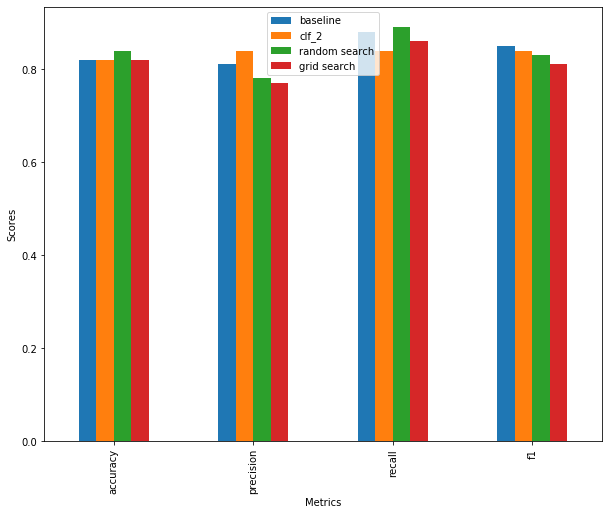

In [20]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "clf_2": clf_2_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})
compare_metrics.plot.bar(figsize=(10, 8));
plt.xlabel('Metrics')
plt.ylabel('Scores')

It seems, even after trying 72 different combinations of hyperparamters, we don't get an improvement in results.

These things might happen. But it's important to remember, it's not over. There may be more we can do.

In a hyperparameter tuning sense, there may be a better set we could find through more extensive searching with RandomizedSearchCV and GridSearchCV but it's likely these improvements will be marginal.

A few next ideas you could try:
* Collecting more data - Based on the results our models are getting now, it seems like they're finding some patterns. Collecting more data may improve a models ability to find patterns. However, your ability to do this will largely depend on the project you're working on.
* Try a more advanced model - Although our tuned Random Forest model is doing pretty well, a more advanced ensemble method such as [XGBoost](https://xgboost.ai/) or [CatBoost](https://catboost.ai/) might perform better.

Now you've got a somewhat tuned Random Forest model, the next thing you might want to do is export it and save it so you could share it with your team or use it in an application without having to retrain it.